In [25]:
# === [1] IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from folium.plugins import MarkerCluster

In [16]:
# === [2] UPLOAD DATASET MANUAL ===
from google.colab import files
uploaded = files.upload()

Saving peta_kecamatan_palembang.geojson to peta_kecamatan_palembang.geojson
Saving hasil_prediksi_kerawanan.csv to hasil_prediksi_kerawanan.csv


In [4]:
# === [3] LOAD DATASET ===
curah_hujan = pd.read_csv('curah_hujan_palembang_2018_2022.csv')
historis_banjir = pd.read_csv('historis_banjir_palembang_2015_2022.csv')
data_non_spatial = pd.read_csv('data_non_spatial_per_kecamatan.csv')

In [5]:
# === [4] STANDARISASI NAMA KOLOM ===
curah_hujan.rename(columns={'nama_kecamatan': 'kecamatan'}, inplace=True)
data_non_spatial.rename(columns={
    'Kecamatan': 'kecamatan',
    'Ketinggian (mdpl)': 'ketinggian_mdpl',
    'Kemiringan Lereng (%)': 'kemiringan_lereng',
    'Penggunaan Lahan': 'penggunaan_lahan'
}, inplace=True)


In [6]:
# === [5] GABUNGKAN DATA ===
merged = pd.merge(historis_banjir, curah_hujan, how='inner', on=['kecamatan', 'tahun'])
merged = pd.merge(merged, data_non_spatial, how='left', on='kecamatan')

In [8]:
# === [6] BUAT LABEL RAWAN BANJIR ===
def label_kerawanan(cm):
    if cm < 50:
        return 0  # Tidak rawan
    elif cm < 100:
        return 1  # Rawan sedang
    else:
        return 2  # Sangat rawan

merged['label_kerawanan'] = merged['ketinggian_air_cm'].apply(label_kerawanan)


In [9]:
# === [7] ENCODING & SCALING ===
label_encoder = LabelEncoder()
merged['penggunaan_lahan'] = label_encoder.fit_transform(merged['penggunaan_lahan'])

features = ['curah_hujan_mm', 'ketinggian_mdpl', 'kemiringan_lereng', 'penggunaan_lahan']
X = merged[features]
y = merged['label_kerawanan']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# === [8] SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:
# === [9] TRAINING MODEL ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# === [10] EVALUASI ===
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.40      0.40      0.40         5
           2       0.57      0.57      0.57         7

    accuracy                           0.53        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.53      0.53      0.53        15



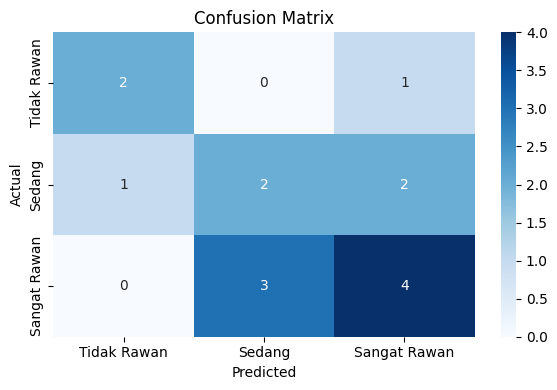

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Rawan', 'Sedang', 'Sangat Rawan'],
            yticklabels=['Tidak Rawan', 'Sedang', 'Sangat Rawan'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [14]:
# Feature Importance
importances = model.feature_importances_
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")


curah_hujan_mm: 0.5818
ketinggian_mdpl: 0.2018
kemiringan_lereng: 0.1495
penggunaan_lahan: 0.0669


In [30]:
# 6. Visualisasi Hasil Prediksi
# ----------------------
m = folium.Map(location=[-2.9909, 104.7566], zoom_start=12, tiles='CartoDB positron')
marker_cluster = MarkerCluster().add_to(m)

color_dict = {0: 'green', 1: 'orange', 2: 'red'}
label_dict = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}

# Simulasi koordinat (karena data tidak punya lat/lon asli)
import random
# Simulasi koordinat sekitar Palembang
np.random.seed(42)
merged['lat'] = -2.9909 + np.random.normal(0, 0.01, len(merged))
merged['lon'] = 104.7566 + np.random.normal(0, 0.01, len(merged))

for _, row in merged.iterrows():
    bounds = [
        [row['lat'] - 0.005, row['lon'] - 0.005],
        [row['lat'] + 0.005, row['lon'] + 0.005]
    ]
    folium.Rectangle(
        bounds=bounds,
        color=color_dict[row['label_kerawanan']],
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(f"{row['kecamatan']}Prediksi: {label_dict[row['label_kerawanan']]}", max_width=250)
    ).add_to(marker_cluster)

# Tambahkan legenda statis
legend_html = '''

    Keterangan:
    ■ Rawan Rendah
    ■ Rawan Sedang
    ■ Rawan Tinggi

'''
m.get_root().html.add_child(folium.Element(legend_html))

# Simpan peta
m.save("result_prediksi_banjir_palembang.html")